### Data Science Case Study Options 

Please select and complete one of the following case studies. We are looking for you to show off your  machine learning and coding skills using Python or R. You are not required to use AWS in your solution,  but you are welcome to spin up an EC2 instance if you would like to. If you use any AWS services please  remember to terminate them after you complete the exercise. 

Please Note: 
- Do not post solution on GitHub or any other online public site 
- Submit a work sample that is comprehensive with respect to your thought process, code, findings,  and recommendations (ie a notebook with annotations). You may submit other documents if you wish. 

Please send the completed work sample at least 1 days prior to the virtual interview. On the day of the  interview you will need access to a laptop/desktop as you will be sharing your screen and going through  the work sample with the interviewer. 
Please send a document displaying your code, annotations, and thought process in a PDF to  kdalenbe@amazon.com and CC your recruiter at least 24 hours prior to your interview. 

## Option 2: Geological Image Similarity 

BACKGROUND 
A geology research company wants to create a tool for identifying interesting patterns in their imagery  data. This tool will possess a search capability whereby an analyst provides an image of interest and is  presented with other images which are similar to it.

GOAL 
Your task is to create the machine learning component for this image similarity application. The machine  learning model should return the top K images that are most similar to this image based on a single  image input.

In [1]:
import os 
from PIL import Image, ImageOps
import pandas as pd
import pathlib
import time
import numpy as np

import cv2

from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
from matplotlib import offsetbox
%matplotlib inline

import torch
import torchvision
from vit_pytorch import ViT
from vit_pytorch.extractor import Extractor

import glob
from pandas.core.common import flatten
import random

from sklearn.neighbors import NearestNeighbors

In [2]:
cwd_path = os.getcwd()
print('Project Folder:')
print(cwd_path)

Project Folder:
/home/david/Documents/projects/aws_geo_sim


In [3]:
data_path = os.path.join(cwd_path,'data','geological_similarity')
try:
    if os.path.isdir(data_path)==True:
        print('(Success) Data Path:')
        print(data_path)
    else:
        raise FileNotFoundError
except FileNotFoundError:
    print('(ERROR) Extracted data folder is not found at:')
    print(data_path)

(Success) Data Path:
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity


In [4]:
all_file_paths = []

print('Data Folders:')
for root, dirs, files in os.walk(data_path):
    for name in dirs:
        print(os.path.join(root, name))
    for name in files:
        all_file_paths.append(os.path.join(root, name))

#all_files = [element for sublist in all_file_paths for element in sublist]
print('Number of Image Files:')
print(len(all_file_paths))

Data Folders:
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/schist
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/quartzite
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/andesite
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/rhyolite
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/gneiss
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/marble
Number of Image Files:
29998


In [5]:
# Using PIL for speed vs OpenCV

def get_metadata_single(img_path):
    class_label = pathlib.PurePath(img_path).parent.name
    img = Image.open(img_path)
    width, height = img.size
    color_space = img.mode
    colors = len(img.getbands())

    # Add image file name
    dic = {'image_path': img_path,
            'class': class_label,
            'width': width,
            'height': height,
            'color': color_space,
            'channels': colors}

    return dic

In [6]:
list_of_dics = []
for file_path in all_file_paths:
    list_of_dics.append(get_metadata_single(file_path))

imgs_df = pd.DataFrame.from_dict(list_of_dics)
imgs_df

,image_path,class,width,height,color,channels
0,/home/david/Documents/projects/aws_geo_sim/dat...,schist,28,28,RGB,3
1,/home/david/Documents/projects/aws_geo_sim/dat...,schist,28,28,RGB,3
2,/home/david/Documents/projects/aws_geo_sim/dat...,schist,28,28,RGB,3
3,/home/david/Documents/projects/aws_geo_sim/dat...,schist,28,28,RGB,3
4,/home/david/Documents/projects/aws_geo_sim/dat...,schist,28,28,RGB,3
...,...,...,...,...,...,...
29993,/home/david/Documents/projects/aws_geo_sim/dat...,marble,28,28,RGB,3
29994,/home/david/Documents/projects/aws_geo_sim/dat...,marble,28,28,RGB,3
29995,/home/david/Documents/projects/aws_geo_sim/dat...,marble,28,28,RGB,3
29996,/home/david/Documents/projects/aws_geo_sim/dat...,marble,28,28,RGB,3


In [7]:
type_counts = imgs_df['class'].value_counts()
type_counts = dict(type_counts)
print(type_counts)

imgs_df['class'].value_counts()
# Wow, talk about a toy dataset...
# I've never seen a dataset so well balanced...

{'schist': 5000, 'quartzite': 5000, 'andesite': 5000, 'rhyolite': 5000, 'gneiss': 5000, 'marble': 4998}


schist       5000
quartzite    5000
andesite     5000
rhyolite     5000
gneiss       5000
marble       4998
Name: class, dtype: int64

In [41]:
def plot_embeddings(X, pixels, title=None):
    
    # Normalize embedding values
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)   

    # Plot all the embeddings
    plt.figure()
    if X.shape[0] <= 6:
        plt.figure(figsize=(5,5))
    else:
        plt.figure(figsize=(15,15))
    ax = plt.subplot(111)
    plt.scatter(X[:, 0], X[:, 1], marker='.')
    plt.xticks([]) 
    plt.yticks([])

    # Show thumbnails
    shown_images = np.array([[1., 1.]])
    for i in range(X.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3 and X.shape[0] > 6:
            continue # don’t show points that are too close
        shown_images = np.r_[shown_images, [X[i]]]

        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(pixels[i,:,:,0:3] / 255), X[i])
        ax.add_artist(imagebox)

### Vision Transformer
Code from https://towardsdatascience.com/a-demonstration-of-using-vision-transformers-in-pytorch-mnist-handwritten-digit-recognition-407eafbc15b0

Creative Commons Attribution 4.0 License https://creativecommons.org/licenses/by/4.0/

https://github.com/lucidrains/vit-pytorch

MIT License https://github.com/lucidrains/vit-pytorch/blob/main/LICENSE

Copyright (c) 2020 Phil Wang

### PyTorch Custom Datasets
https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895


In [9]:
train_image_paths = [] #to store image paths in list
train_image_class = [] #to store class values

# get all the paths from data_path and append image paths and class to to respective lists
for img_path in glob.glob(data_path + '/*'):
    train_image_class.append(img_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(img_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))

idx_to_class = {i:j for i, j in enumerate(train_image_class)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [10]:
class MyDataset(torchvision.datasets.VisionDataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        return image, label

In [11]:
data_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(
        (0.50836704, 0.51988116, 0.51973073),(0.18507581, 0.19952308, 0.21939567))])

train_dataset = MyDataset(train_image_paths, transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()
    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = torch.nn.functional.log_softmax(model(data), dim=1)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

def evaluate(model, data_loader, loss_history):
    model.eval()
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = torch.nn.functional.log_softmax(model(data), dim=1)
            loss = torch.nn.functional.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()
    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('Average test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [12]:
N_EPOCHS = 1
model = ViT(image_size=28, patch_size=7, num_classes=6, channels=3,
            dim=64, depth=6, heads=8, mlp_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

train_loss_history, test_loss_history = [], []
start_time = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, train_loader, test_loss_history)
print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/29998 (  0%)]  Loss: 1.8380
[ 6400/29998 ( 21%)]  Loss: 0.2856
[12800/29998 ( 43%)]  Loss: 0.2571
[19200/29998 ( 64%)]  Loss: 0.2191
[25600/29998 ( 85%)]  Loss: 0.3621
Average test loss: 0.1645  Accuracy:28334/29998 (94.45%)

Execution time: 62.34 seconds


Arrays created for: schist
TSNE embeddings created for: schist


/home/david/miniforge3/envs/aws_geo_sim/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/david/miniforge3/envs/aws_geo_sim/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


<Figure size 432x288 with 0 Axes>

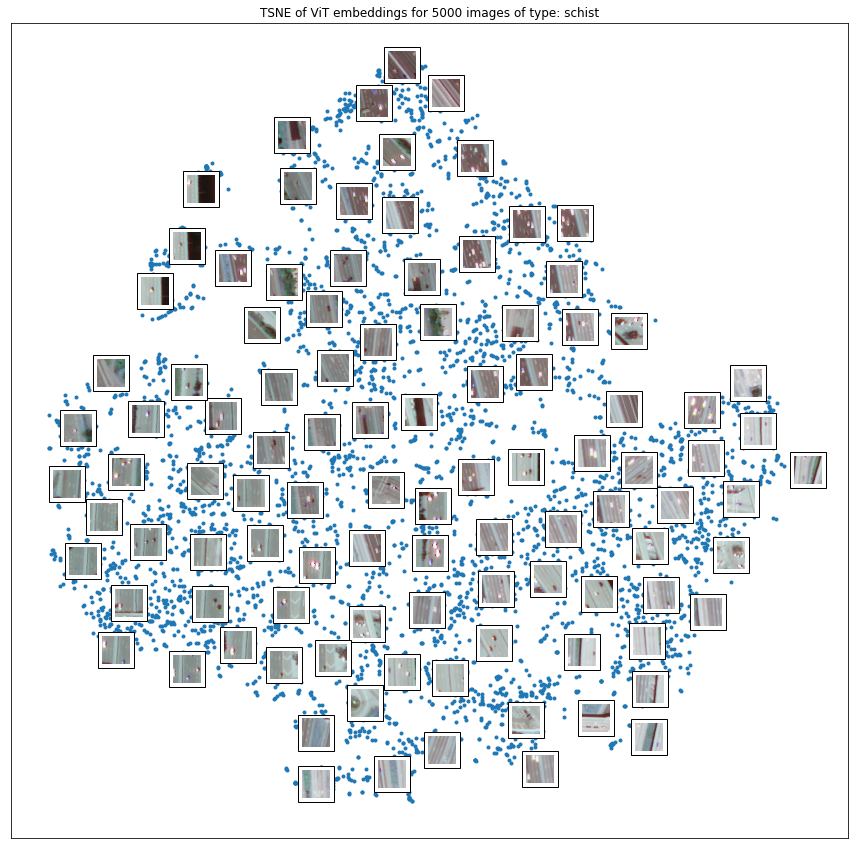

Arrays created for: quartzite
TSNE embeddings created for: quartzite


<Figure size 432x288 with 0 Axes>

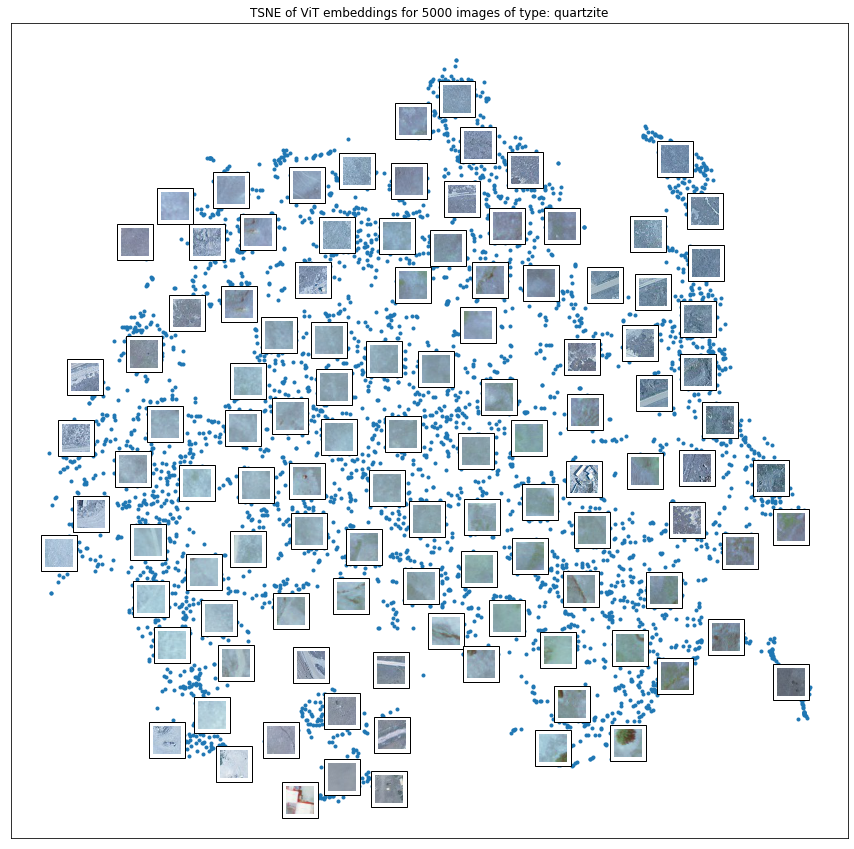

Arrays created for: andesite
TSNE embeddings created for: andesite


<Figure size 432x288 with 0 Axes>

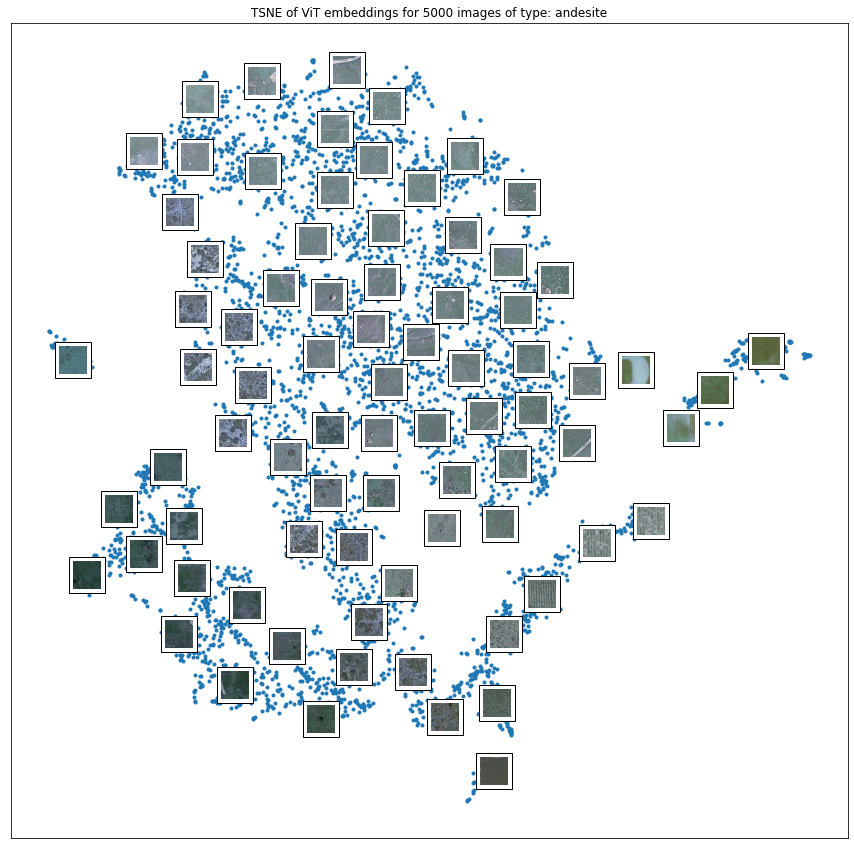

Arrays created for: rhyolite
TSNE embeddings created for: rhyolite


<Figure size 432x288 with 0 Axes>

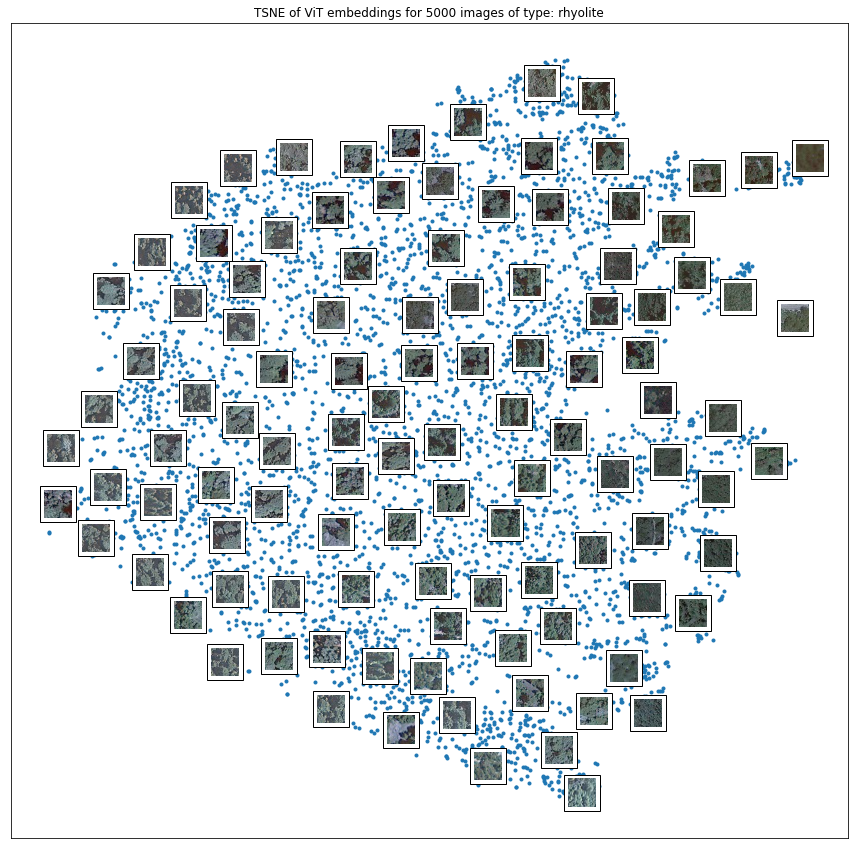

Arrays created for: gneiss
TSNE embeddings created for: gneiss


<Figure size 432x288 with 0 Axes>

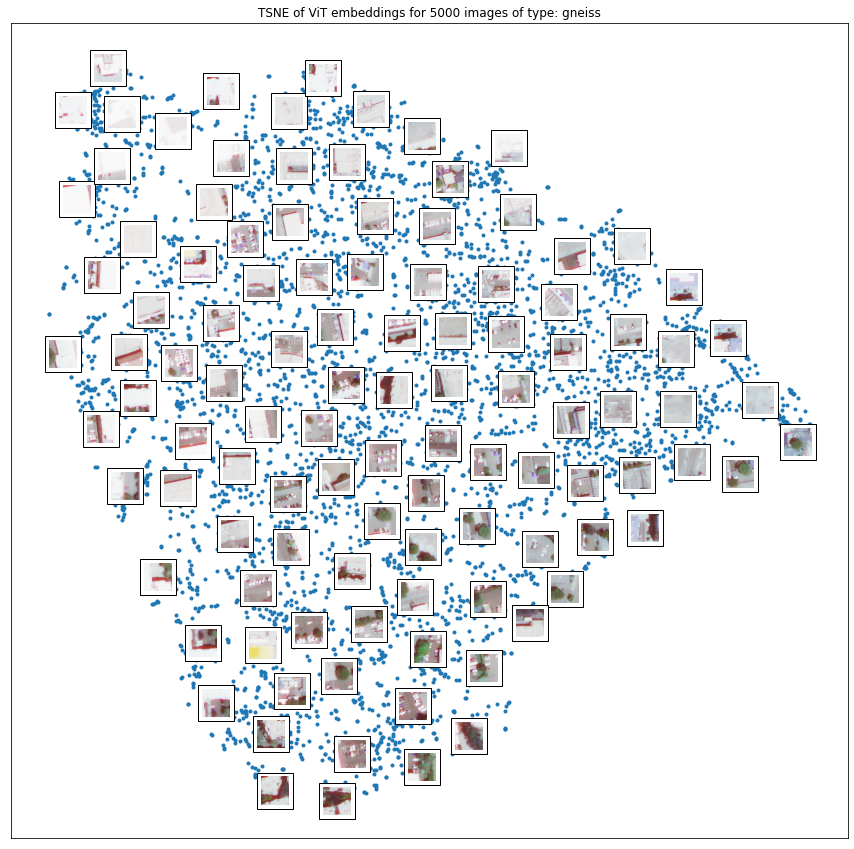

Arrays created for: marble
TSNE embeddings created for: marble


<Figure size 432x288 with 0 Axes>

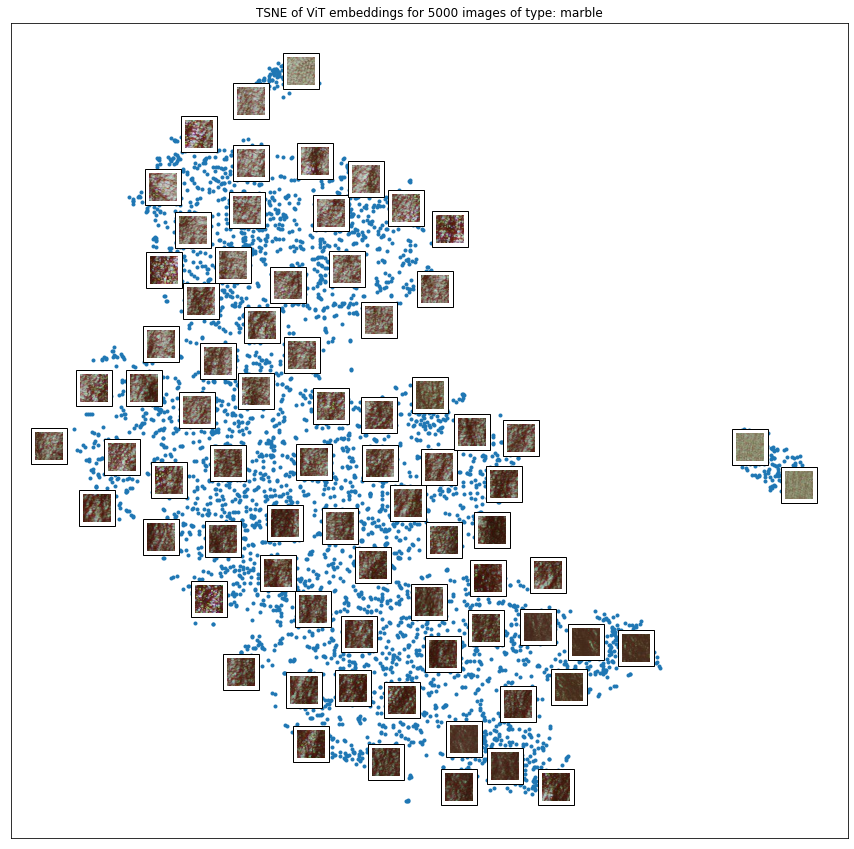

In [13]:
embed_model = Extractor(model)

for class_type, img_count in type_counts.items():
    rgb_data = np.zeros((img_count,28,28,3))
    nn_embed = np.zeros((img_count,17,64))
    
    img_paths = list(flatten(imgs_df[imgs_df['class']==class_type]['image_path']))
    dataset = MyDataset(img_paths, transform=data_transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

    for i, (data, target) in enumerate(loader):
        rgb_data[i,:,:,0:3] = np.array(Image.open(img_paths[i]))
        logits, embed = embed_model(data)
        nn_embed[i,:,:] = embed
    print('Arrays created for:',class_type)

    flat_data = np.reshape(nn_embed, (img_count,17*64))
    embeddings = TSNE(n_jobs=8).fit_transform(flat_data)
    print('TSNE embeddings created for:',class_type)
    
    plot_embeddings(embeddings,rgb_data)
    plt.title("TSNE of ViT embeddings for 5000 images of type: "+class_type)
    plt.show()

Arrays created for: ALL IMAGES
TSNE embeddings created for: ALL IMAGES


<Figure size 432x288 with 0 Axes>

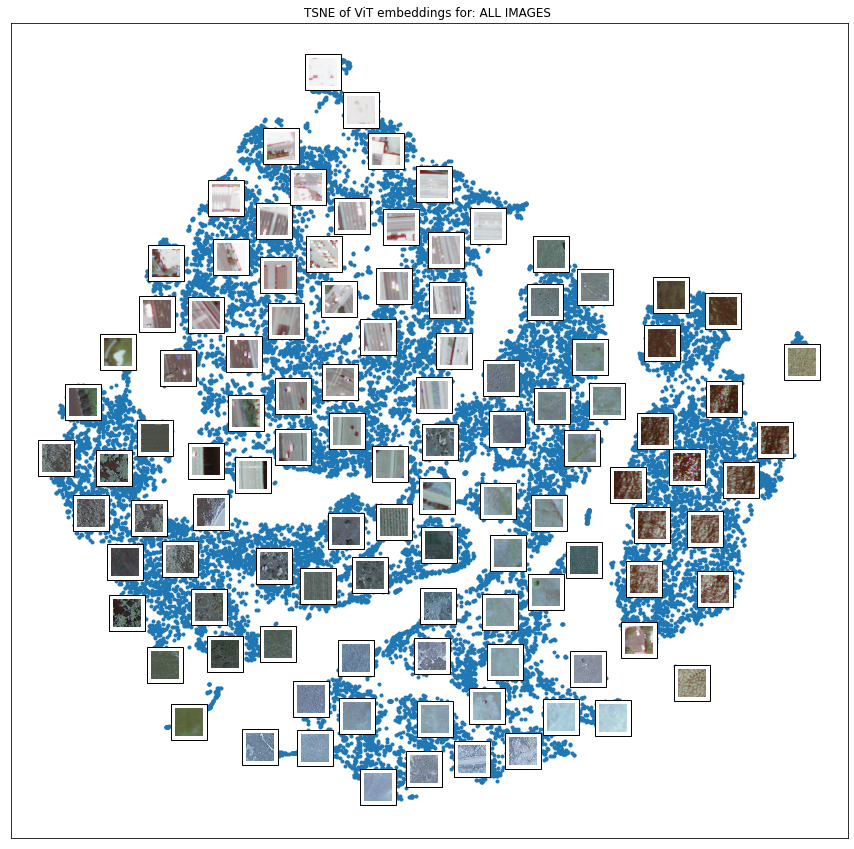

In [14]:
img_count = len(imgs_df)
rgb_data = np.zeros((img_count,28,28,3))
nn_embed = np.zeros((img_count,17,64))

img_paths = list(flatten(imgs_df['image_path']))
dataset = MyDataset(img_paths, transform=data_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

for i, (data, target) in enumerate(loader):
    rgb_data[i,:,:,0:3] = np.array(Image.open(img_paths[i]))
    logits, embed = embed_model(data)
    nn_embed[i,:,:] = embed
print('Arrays created for: ALL IMAGES')

flat_data = np.reshape(nn_embed, (img_count,17*64))
embeddings = TSNE(n_jobs=8).fit_transform(flat_data)
print('TSNE embeddings created for: ALL IMAGES')

plot_embeddings(embeddings,rgb_data)
plt.title("TSNE of ViT embeddings for: ALL IMAGES ")
plt.show()

<Figure size 432x288 with 0 Axes>

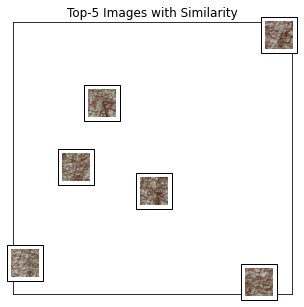

In [104]:
rand_img_idx = random.randint(0,len(imgs_df)-1)
img_loc = embeddings[rand_img_idx].reshape(1, -1)

nbrs = NearestNeighbors(n_neighbors=6).fit(embeddings)
indices = nbrs.kneighbors(img_loc, return_distance=False)[0]

top_five_emb = np.zeros((6,2))
top_five_rgb = np.zeros((6,28,28,3))

for i in range(6):
    top_five_emb[i,:] = embeddings[indices[i],:]
    top_five_rgb[i,:,:,:] = rgb_data[indices[i],:,:,:]

plot_embeddings(top_five_emb,top_five_rgb)
plt.title("Top-5 Images with Similarity")
plt.show()